# Code for analysing NFL play-by-play data, 2013-2015

This notebook contains the code I used to analyze the NFL play-by-play data from 2013-2015, specifically looking at correlation between how consistantly teams gains yards and total scoring. The discussion of the results in on my blog. The original data came from NFLSavant.com and the combined, cleaned up CSV is available on my GitHub page.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.style as plt_style
plt_style.use('ggplot')
import statsmodels.formula.api as sm
import statsmodels.graphics.regressionplots as reg_plts
%matplotlib inline

In [2]:
csv_url = 'https://raw.githubusercontent.com/scottmcneil/blog-code/master/NFL%20Consistency/2013-2015%20play-by-play.csv'
raw_df = pd.read_csv(csv_url) #import CSV from GitHub
raw_df = raw_df[raw_df.Down != 0] # Want to eliminate non-plays such as timeouts and end-of-quarter

In [3]:
#Needed to add some additional data to the dataframe
#Create unique ID for the two offenses in each game
raw_df['GameTeamId'] = raw_df.GameId.map(str) + raw_df.OffenseTeam 

#Need to be able to order by half since drives can cross over quarters
raw_df['Half'] = (raw_df['Quarter']>2) + 1 
raw_df['HalfMinute'] = raw_df['Minute'] + raw_df['Quarter']%2*15
raw_df.sort_values(['GameId','Half','HalfMinute','Second'], ascending=[True,True,False,False], inplace=True) #
#Isolate first play of each drive by offense team switching
raw_df['IsDriveFirstPlay'] = raw_df.GameTeamId!= raw_df.GameTeamId.shift()

#CSV did not contain data for good field goals, needed to add extra column using Description column
raw_df['IsFieldGoal'] = (raw_df.PlayType == 'FIELD GOAL') & (raw_df.Description.str.contains('IS GOOD'))

In [4]:
#With the expanded dataframe, need to create filtered dataframes and groupby objects for aggregating data:
#Create two dataframes, one with all non-reversed plays, and one with just offensive plays
completed_play_df = raw_df[
                        (raw_df.IsChallengeReversed == False)
                        & (raw_df.IsNoPlay == False)
                        & (raw_df.IsPenaltyAccepted == False)
                        ]
offense_play_df = completed_play_df[
                        (completed_play_df.PlayType != 'PUNT')
                        & (completed_play_df.PlayType != 'FIELD GOAL')
                        & (completed_play_df.IsInterception == False)
                        & (completed_play_df.IsFumble == False)
                        ]

#Creating groupby objects
#Groupby object with just data from beginning of each drive
drive_groupby = raw_df[raw_df.IsDriveFirstPlay == True].groupby(raw_df.GameTeamId)

#Groupby object with all offensive plays (filtering is due to numpy error related to stdev)
offense_groupby = offense_play_df[['GameTeamId','Yards','IsTouchdown']].groupby(offense_play_df.GameTeamId)

#Groupby objects by down
first_down_groupby = offense_play_df[offense_play_df.Down == 1][['GameTeamId','Yards']].groupby(completed_play_df.GameTeamId)
second_down_groupby = offense_play_df[offense_play_df.Down == 2][['GameTeamId','Yards']].groupby(completed_play_df.GameTeamId)
third_down_groupby = offense_play_df[offense_play_df.Down == 3][['GameTeamId','Yards']].groupby(completed_play_df.GameTeamId)

#Groupby objects split between passing and rushing
passing_groupby = offense_play_df[offense_play_df.IsPass == True][['GameTeamId','Yards']].groupby(completed_play_df.GameTeamId)
rushing_groupby = offense_play_df[offense_play_df.IsRush == True][['GameTeamId','Yards']].groupby(completed_play_df.GameTeamId)

In [5]:
#Now creating the aggregated dataframe
#Initialize dataframe for aggregating data
total_df = pd.DataFrame(index=offense_play_df.GameTeamId.unique())

#Adding column with just offensive scores
total_df['OffensiveScore'] = offense_groupby.sum().IsTouchdown * 7 + completed_play_df.groupby(completed_play_df.GameTeamId).sum().IsFieldGoal * 3

#Adding data for turnovers and penalties
total_df['Turnovers'] = completed_play_df[(completed_play_df.IsInterception == True) | (completed_play_df.IsFumble == True)].groupby(completed_play_df.GameTeamId).size()
total_df['OffensivePenaltyYards'] = raw_df[
                                        (raw_df.IsPenaltyAccepted == True)
                                        & (raw_df.PenaltyTeam == raw_df.OffenseTeam)
                                        ].groupby(raw_df.GameTeamId).sum().PenaltyYards

total_df['DefensivePenaltyYards'] = raw_df[
                                        (raw_df.IsPenaltyAccepted == True)
                                        & (raw_df.PenaltyTeam != raw_df.OffenseTeam)
                                        ].groupby(raw_df.GameTeamId).sum().PenaltyYards

#Adding data for offensive opportunities
total_df['OffensiveOpportunities'] = drive_groupby.size()
total_df['AverageStartingPosition'] = drive_groupby.mean().YardLine

#Filtering out all NaN columns (mostly for turnover column)
total_df.fillna(0, inplace=True)

In [6]:
#Adding average yards data
total_df['AverageYards'] = offense_groupby.mean().Yards

#By down
total_df['FirstDownAverage'] = first_down_groupby.mean().Yards
total_df['SecondDownAverage'] = second_down_groupby.mean().Yards
total_df['ThirdDownAverage'] = third_down_groupby.mean().Yards

#By passing and rushing
total_df['PassingAverage'] = passing_groupby.mean().Yards
total_df['RushingAverage'] = rushing_groupby.mean().Yards

#Addding variance in yards data
total_df['VarianceYards'] = offense_groupby.var().Yards

#By down
total_df['FirstDownVariance'] = first_down_groupby.var().Yards
total_df['SecondDownVariance'] = second_down_groupby.var().Yards
total_df['ThirdDownVariance'] = third_down_groupby.var().Yards

#By passing and rushing
total_df['PassingVariance'] = passing_groupby.var().Yards
total_df['RushingVariance'] = rushing_groupby.var().Yards

#Addding standard deviation in yards data
total_df['StdevYards'] = offense_groupby.std().Yards

#By down
total_df['FirstDownStdev'] = first_down_groupby.std().Yards
total_df['SecondDownStdev'] = second_down_groupby.std().Yards
total_df['ThirdDownStdev'] = third_down_groupby.std().Yards

#By passing and rushing
total_df['PassingStdev'] = passing_groupby.std().Yards
total_df['RushingStdev'] = rushing_groupby.std().Yards

In [7]:
formula = 'OffensiveScore ~ VarianceYards + AverageYards + Turnovers + OffensivePenaltyYards + DefensivePenaltyYards + OffensiveOpportunities + AverageStartingPosition'
result = sm.ols(formula=formula, data=total_df).fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:         OffensiveScore   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     315.3
Date:                Wed, 13 Jan 2016   Prob (F-statistic):          1.68e-292
Time:                        18:06:50   Log-Likelihood:                -5031.1
No. Observations:                1556   AIC:                         1.008e+04
Df Residuals:                    1548   BIC:                         1.012e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [8]:
print result.params['VarianceYards'] * total_df.VarianceYards.std()/result.params['AverageYards'] * total_df.AverageYards.std()

-0.161500728113


In [9]:
formula_downs = 'OffensiveScore ~ FirstDownVariance + SecondDownVariance + ThirdDownVariance + AverageYards + Turnovers + OffensivePenaltyYards + DefensivePenaltyYards + OffensiveOpportunities + AverageStartingPosition'
result_downs = sm.ols(formula=formula_downs, data=total_df).fit()
print result_downs.summary()

                            OLS Regression Results                            
Dep. Variable:         OffensiveScore   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     246.1
Date:                Wed, 13 Jan 2016   Prob (F-statistic):          6.26e-291
Time:                        18:06:52   Log-Likelihood:                -5029.0
No. Observations:                1556   AIC:                         1.008e+04
Df Residuals:                    1546   BIC:                         1.013e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [10]:
print result_downs.params['FirstDownVariance'] * total_df.FirstDownVariance.std()/result_downs.params['AverageYards'] * total_df.AverageYards.std()
print result_downs.params['SecondDownVariance'] * total_df.SecondDownVariance.std()/result_downs.params['AverageYards'] * total_df.AverageYards.std()

-0.137390599461
-0.106767726835


In [11]:
formula_type = 'OffensiveScore ~ PassingVariance + RushingVariance + PassingAverage + RushingAverage + Turnovers + OffensivePenaltyYards + DefensivePenaltyYards + OffensiveOpportunities + AverageStartingPosition'
result_type = sm.ols(formula=formula_type, data=total_df).fit()
print result_type.summary()

                            OLS Regression Results                            
Dep. Variable:         OffensiveScore   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     183.8
Date:                Wed, 13 Jan 2016   Prob (F-statistic):          6.41e-237
Time:                        18:06:54   Log-Likelihood:                -5154.6
No. Observations:                1556   AIC:                         1.033e+04
Df Residuals:                    1546   BIC:                         1.038e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
print result_type.params['PassingVariance'] * total_df.PassingVariance.std()/result_type.params['PassingAverage'] * total_df.AverageYards.std()

-0.385043123456


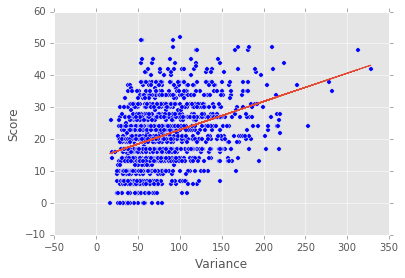

In [14]:
fit = np.polyfit(total_df.VarianceYards, total_df.OffensiveScore, deg=1)
plt.pyplot.plot(total_df.VarianceYards, fit[0] * total_df.VarianceYards + fit[1])
plt.pyplot.scatter(total_df.VarianceYards, total_df.OffensiveScore)
plt.pyplot.xlabel('Variance')
plt.pyplot.ylabel('Score')

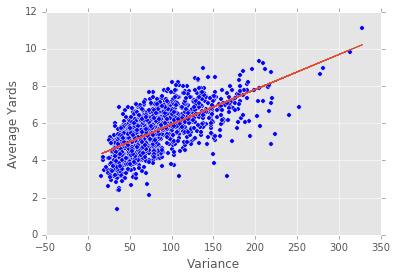

In [17]:
fit = np.polyfit(total_df.VarianceYards, total_df.AverageYards, deg=1)
plt.pyplot.plot(total_df.VarianceYards, fit[0] * total_df.VarianceYards + fit[1])
plt.pyplot.scatter(total_df.VarianceYards, total_df.AverageYards)
plt.pyplot.xlabel('Variance')
plt.pyplot.ylabel('Average Yards')

In [18]:
predictions = result.predict(total_df)

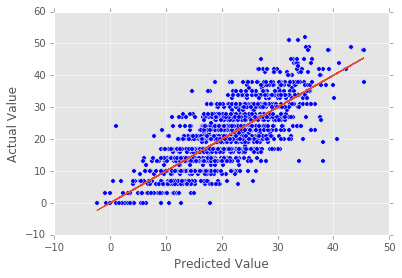

In [19]:
fit = np.polyfit(predictions, total_df.OffensiveScore, deg=1)
plt.pyplot.plot(predictions, fit[0] * predictions + fit[1])
plt.pyplot.scatter(predictions, total_df.OffensiveScore)
plt.pyplot.xlabel('Predicted Value')
plt.pyplot.ylabel('Actual Value')

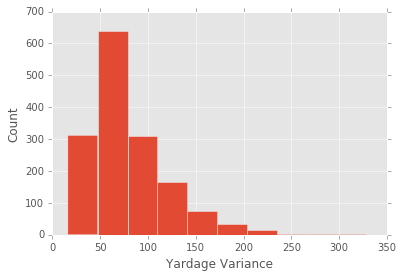

In [20]:
plt.pyplot.hist(total_df.VarianceYards)
plt.pyplot.xlabel('Yardage Variance')
plt.pyplot.ylabel('Count')